In [11]:
!pip install osmnx networkx shapely ipyleaflet ipywidgets

In [1]:
import osmnx as ox
import networkx as nx
import ipyleaflet as ipl
import pickle
import shapely

from shapely.geometry import Polygon
from ipyleaflet import Map, Marker, FullScreenControl, AwesomeIcon
from ipywidgets import interact
from time import sleep

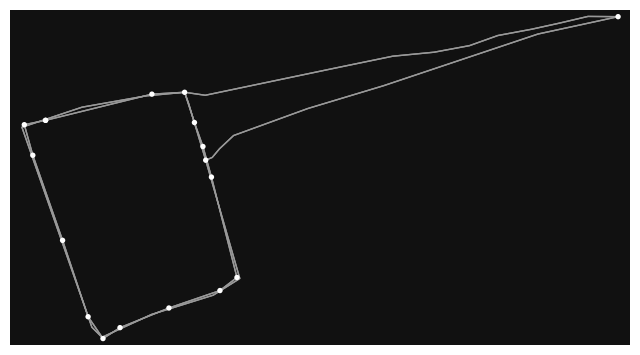

In [2]:
# Setting up graph for CMRIT
## Using boundbox

# north, south, east, west = 12.96768338736144,12.965518842636625,77.71393642911939,77.71046157295785
# # cmrit lat long bounds 0
# # north (float) – northern latitude of bounding box: 12.96768338736144
# # south (float) – southern latitude of bounding box: 12.965518842636625
# # east (float) – eastern longitude of bounding box: 77.71393642911939
# # west (float) – western longitude of bounding box: 77.71046157295785
# network_type = 'all_private' # "all_private", "all", "bike", "drive", "drive_service", "walk"

# G = ox.graph_from_bbox(
#       north, south, east, west, 
#       network_type=network_type, 
#       simplify=False, 
#       retain_all=False, 
#       truncate_by_edge=True, 
#       clean_periphery=True, 
#       custom_filter=None)

# Setting up the graph using the pickle file
filename = "../output/geocode_tree.pkl"

with open(filename, "rb") as f:
    G = pickle.load(f)

# Plot the graph
fig, ax = ox.plot_graph(G)

In [3]:
sorted(G.nodes)

['basic_science',
 'cmrit_entrance',
 'ganesha_statue',
 'hostel_turn',
 't-1',
 't-10',
 't-11',
 't-12',
 't-2',
 't-3',
 't-4',
 't-5',
 't-6',
 't-7',
 't-8',
 't-9',
 'teacher_parking',
 'volley_ball_court']

In [4]:
# Finding the shortest path with the given start and end lat-lng
optimizer = 'length'

orig_node = "basic_science"
dest_node = "hostel_turn"

shortest_route = nx.shortest_path(G, orig_node, dest_node, weight=optimizer)

shortest_route_map = ox.plot_route_folium(G, shortest_route)
shortest_route_map

In [5]:
# Finding the longest path with the given start and end nodes

longest_path = []
for i in range(len(shortest_route) - 1):
    start = shortest_route[i]
    end = shortest_route[i+1]
    G.remove_edge(start, end)
    for path in nx.all_simple_paths(G, start, end):
        if len(path) > len(longest_path):
            longest_path = path
    G.add_edge(start, end)

longest_route_map = ox.plot_route_folium(G, longest_path)
longest_route_map

In [6]:
# To find the coordinates in the shortest path
route_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in shortest_route]
route_coords

[(12.96626, 77.71211),
 (12.9662, 77.71203),
 (12.96612, 77.71179),
 (12.96603, 77.71156),
 (12.96598, 77.71148),
 (12.96608, 77.71141),
 (12.96643, 77.71129),
 (12.96682, 77.71115),
 (12.96696, 77.71111)]

In [7]:
# Plotting the interactive map with the center at (12.96682, 77.71231) => This center is for the map plotting not related with the graph
center = (12.96682, 77.71231)
m1 = ipl.Map(center=center, basemap=ipl.basemaps.CartoDB.Positron, zoom=18)
m1.layout.height = '800px'

In [8]:
# Drawing the path in the interactive map
path = {}
# Setting up the path dict for future use
for i in shortest_route:
  path[i] = [G.nodes[i]['y'],G.nodes[i]['x']]

lines = ipl.Polyline(
    locations=list(path.values()),
    color="tomato",
    fill=False
)
m1.add_layer(lines)

In [9]:
# Adding markers in the interactive map
icon1 = AwesomeIcon(
    name='fa-truck',
    marker_color='green',
    icon_color='black',
    spin=False
)

marker = ipl.Marker(icon=icon1, location=[G.nodes[orig_node]['y'],G.nodes[orig_node]['x']])
m1.add_layer(marker)

In [10]:
import re
# Setting up trees on the path
pattern = r't\-[0-9]+'
for point_name in list(path.keys()):
  if re.match(pattern, point_name):
    # Draw circle for the point
    circle = ipl.Circle(
        location=path[point_name],
        radius=2,
        color="DimGray",
        fill_color="SkyBlue",
        fill=True,
        fill_opacity=0.85
    )
    m1.add_layer(circle)

In [11]:
# Showing the map before animation
m1

Map(center=[12.96682, 77.71231], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

In [12]:
# Animation
# Moving the marker according to the path
step = 0.5 # Speed can be varied here... higher the value lower the speed
start_location = marker.location
from time import sleep
for point in path:
  marker.location = path[point]
  if re.match(pattern, point):
    # Tree encountered
    sleep(1)
    visited = ipl.Circle(
        location=path[point],
        radius=2,
        color="#00b521",
        fill_color="#7fff96",
        fill=True,
        fill_opacity=0.85
    )
    m1.add_layer(visited)
  
  sleep(step)


In [13]:
"""
NOTE:: Don't interact with the map as the kernel will get busy and it will crash
The animation will be shown after the map is drawn
"""

"\nNOTE:: Don't interact with the map as the kernel will get busy and it will crash\nThe animation will be shown after the map is drawn\n"

Simulation of Vehicle running on low battery

In [14]:
# Finding optimal path when vehicle running on low battery

current_vehicle_location = "t-4" # Let's assume its at tree 4
base_location = "basic_science" # This is the charging station

range = 200 # Let us take the range in meters

shortest_route = nx.shortest_path(G, current_vehicle_location, base_location, weight=optimizer)
route_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in shortest_route]


total_distance = sum(ox.distance.great_circle_vec(float(lat1), float(lng1), float(lat2), float(lng2)) 
                     for (lat1, lng1), (lat2, lng2) in zip(route_coords[:-1], route_coords[1:]))

if range >= total_distance:
  # The vehicle can move to base
  step = 1.5
  marker.location = route_coords[0]
  marker.color = "red"
  try:
    # Removing the current path
    m1.remove_layer(lines)
  except:
    pass
  # Adding the path from the given nodes
  shortest_path = ipl.Polyline(
    locations=route_coords,
    color="tomato",
    fill=False
  )
  m1.add_layer(shortest_path)
  # Move the vehicle
  for point in route_coords:
    marker.location = point
    sleep(step)

else:
  print("Vehicle cannot move with the given battery level range")